In [1]:
# 0. IMPORTS & CONFIGURATION

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

# Statistics for Finance (Cointegration tests, ADF)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint

# Machine Learning - Preprocessing & Models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# GLOBAL CONFIGURATION

# 1. Graphic style ---> Done with AI
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)  # Default figure size

# 2. Pandas configuration (to see DataFrames properly) ---> Done with AI
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 1000)
pd.set_option("display.float_format", "{:.4f}".format)

# 3. Reproducibility (Crucial for presentation/grading)
np.random.seed(42)

print("Environment successfully configured.")
print(f"NumPy: {np.__version__} | Pandas: {pd.__version__}")


Environment successfully configured.
NumPy: 2.0.2 | Pandas: 2.2.2


In [2]:
# 1. GET S&P 500 TICKERS

import pandas as pd

sp500_url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"

sp500_table = pd.read_csv(sp500_url)

tickers = sp500_table["Symbol"].tolist()

# Yahoo Finance replaces "." with "-"
tickers = [t.replace(".", "-") for t in tickers]

print(f"Number of tickers retrieved: {len(tickers)}")
tickers[:15]


Number of tickers retrieved: 503


['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE']

In [3]:
# 2. DOWNLOAD ADJ CLOSE PRICES

import yfinance as yf
import pandas as pd
import numpy as np

start_date = "2014-01-01"
end_date = None

raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,   # important to keep 'Adj Close'
    progress=True
)

print("Raw shape (with OHLC etc.):", raw.shape)

# If yfinance returns a MultiIndex (Open/High/Low/Close/Adj Close)
if isinstance(raw.columns, pd.MultiIndex):
    # Keep only 'Adj Close' prices
    data_raw = raw["Adj Close"].copy()
else:
    # Otherwise, assume prices are already provided
    data_raw = raw.copy()

# Drop columns that are entirely NaN (e.g., delisted stocks like WBA)
data_raw = data_raw.dropna(axis=1, how="all")

print("Shape after dropping all-NaN columns:", data_raw.shape)
print("First columns:", data_raw.columns[:10])

data_raw.head()


[*****                 10%                       ]  51 of 503 completedERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WBA']: YFTzMissingError('possibly delisted; no timezone found')


Raw shape (with OHLC etc.): (3011, 3018)
Shape after dropping all-NaN columns: (3011, 502)
First columns: Index(['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM'], dtype='object', name='Ticker')


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALL,ALLE,AMAT,...,WAB,WAT,WBD,WDAY,WDC,WEC,WELL,WFC,WM,WMB,WMT,WRB,WSM,WST,WTW,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,36.4514,17.1567,32.1666,NaN,30.3295,18.1843,66.1059,59.2900,38.2543,30.4864,53.8949,49.2500,24.4209,30.0222,9.3696,24.8119,38.5818,51.6735,36.4684,46.5300,52.8790,56.9600,41.3903,38.5044,15.0109,...,68.7320,99.2200,45.5289,81.7700,51.4908,27.4856,33.1805,32.1582,34.4645,19.7235,20.8086,9.7250,22.2426,45.9938,96.4409,19.7184,164.3998,18.8775,60.5183,29.3269,NaN,42.9283,81.3959,53.1800,29.4395
2014-01-03,36.9118,16.7798,32.3646,NaN,30.6547,17.8357,66.3258,59.1600,38.5104,30.6282,54.4820,48.9000,24.3316,30.0092,9.3236,24.8834,38.7415,51.9899,36.4763,46.4500,52.9711,57.1700,41.2202,38.7778,14.9766,...,69.1729,98.0400,45.2632,82.4700,51.8645,27.4518,32.8768,32.3868,34.4567,19.5947,20.7400,9.6932,22.3143,46.4095,95.5678,19.7625,162.7885,18.8706,60.3727,29.5930,NaN,43.1970,81.7488,53.5800,29.1574
2014-01-06,36.7302,16.8713,31.1826,NaN,31.0593,17.6677,65.6251,58.1200,38.2931,30.6920,53.8611,48.5500,24.5790,29.9897,9.4155,24.4056,38.4372,52.3538,36.4447,46.1100,52.8539,59.9000,41.0579,38.5309,14.7885,...,68.3848,98.3900,44.6960,84.5900,51.6216,27.2021,33.6453,32.4439,34.1214,19.7854,20.6240,9.6500,22.3748,46.1544,95.5896,19.5608,162.6722,18.7677,60.4637,29.5415,NaN,43.1627,82.2783,53.4000,29.0938
2014-01-07,37.2555,16.7507,31.2445,NaN,30.8213,17.6740,66.4236,58.9700,38.4949,30.3871,54.5157,49.6800,24.8952,30.1849,9.5797,24.4846,38.9622,52.8601,37.4166,47.0100,53.2140,61.3600,41.2357,38.6985,14.8569,...,68.6288,100.3800,44.4251,88.1300,53.3404,27.6678,33.6267,32.4297,34.3709,20.0997,20.6873,9.6205,22.4692,46.5040,95.8734,19.6175,167.3648,19.0902,61.3192,29.6274,NaN,43.7687,83.9196,53.9500,29.2029
2014-01-08,37.8651,16.8568,31.1641,NaN,31.0990,17.5694,66.9370,58.9000,38.5881,30.0396,54.2256,50.2400,24.7027,30.0027,9.3893,24.3116,39.4187,53.4614,37.2981,46.6800,54.3279,60.7300,41.3671,38.7073,14.8997,...,68.3567,100.4800,43.2345,89.0000,53.8137,27.4586,33.4036,32.8011,34.3007,20.1770,20.5238,9.4820,22.5410,47.1748,96.0262,19.4346,170.5044,19.0147,61.1190,29.6102,NaN,43.7516,85.9757,53.9100,28.8754


In [4]:
# 3. DATA CLEANING

threshold_ratio = 0.95
min_non_na = int(threshold_ratio * len(data_raw))

data = data_raw.dropna(axis=1, thresh=min_non_na).copy()

print(f"Selection criterion: >{threshold_ratio*100:.0f}% valid data.")
print(f"Tickers kept: {data.shape[1]} / {data_raw.shape[1]}")
print(f"Tickers rejected: {data_raw.shape[1] - data.shape[1]} (Too many missing values)")

# Filling remaining gaps (small data glitches)
# 1. Forward Fill: propagate last known value
data = data.ffill()

# 2. Backfill: only for the first days
data = data.bfill()

# If a stock has the same price for 10 years (data bug), it breaks correlations
variance = data.var()
flat_tickers = variance[variance == 0].index
if len(flat_tickers) > 0:
    print(f"Removing zero-variance tickers: {list(flat_tickers)}")
    data = data.drop(columns=flat_tickers)

print(f"Final dataset dimensions: {data.shape}")
data.head()


Selection criterion: >95% valid data.
Tickers kept: 463 / 502
Tickers rejected: 39 (Too many missing values)
Final dataset dimensions: (3011, 463)


Ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALL,ALLE,AMAT,AMCR,...,VZ,WAB,WAT,WBD,WDAY,WDC,WEC,WELL,WFC,WM,WMB,WMT,WRB,WSM,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,36.4514,17.1567,32.1666,30.3295,18.1843,66.1059,59.2900,38.2543,30.4864,53.8949,49.2500,24.4209,30.0222,9.3696,24.8119,38.5818,51.6735,36.4684,46.5300,52.8790,56.9600,41.3903,38.5044,15.0109,5.7388,...,26.5413,68.7320,99.2200,45.5289,81.7700,51.4908,27.4856,33.1805,32.1582,34.4645,19.7235,20.8086,9.7250,22.2426,45.9938,96.4409,19.7184,164.3998,18.8775,60.5183,29.3269,42.9283,81.3959,53.1800,29.4395
2014-01-03,36.9118,16.7798,32.3646,30.6547,17.8357,66.3258,59.1600,38.5104,30.6282,54.4820,48.9000,24.3316,30.0092,9.3236,24.8834,38.7415,51.9899,36.4763,46.4500,52.9711,57.1700,41.2202,38.7778,14.9766,5.6846,...,26.2271,69.1729,98.0400,45.2632,82.4700,51.8645,27.4518,32.8768,32.3868,34.4567,19.5947,20.7400,9.6932,22.3143,46.4095,95.5678,19.7625,162.7885,18.8706,60.3727,29.5930,43.1970,81.7488,53.5800,29.1574
2014-01-06,36.7302,16.8713,31.1826,31.0593,17.6677,65.6251,58.1200,38.2931,30.6920,53.8611,48.5500,24.5790,29.9897,9.4155,24.4056,38.4372,52.3538,36.4447,46.1100,52.8539,59.9000,41.0579,38.5309,14.7885,5.6846,...,26.3733,68.3848,98.3900,44.6960,84.5900,51.6216,27.2021,33.6453,32.4439,34.1214,19.7854,20.6240,9.6500,22.3748,46.1544,95.5896,19.5608,162.6722,18.7677,60.4637,29.5415,43.1627,82.2783,53.4000,29.0938
2014-01-07,37.2555,16.7507,31.2445,30.8213,17.6740,66.4236,58.9700,38.4949,30.3871,54.5157,49.6800,24.8952,30.1849,9.5797,24.4846,38.9622,52.8601,37.4166,47.0100,53.2140,61.3600,41.2357,38.6985,14.8569,5.6966,...,26.7037,68.6288,100.3800,44.4251,88.1300,53.3404,27.6678,33.6267,32.4297,34.3709,20.0997,20.6873,9.6205,22.4692,46.5040,95.8734,19.6175,167.3648,19.0902,61.3192,29.6274,43.7687,83.9196,53.9500,29.2029
2014-01-08,37.8651,16.8568,31.1641,31.0990,17.5694,66.9370,58.9000,38.5881,30.0396,54.2256,50.2400,24.7027,30.0027,9.3893,24.3116,39.4187,53.4614,37.2981,46.6800,54.3279,60.7300,41.3671,38.7073,14.8997,5.7207,...,26.5559,68.3567,100.4800,43.2345,89.0000,53.8137,27.4586,33.4036,32.8011,34.3007,20.1770,20.5238,9.4820,22.5410,47.1748,96.0262,19.4346,170.5044,19.0147,61.1190,29.6102,43.7516,85.9757,53.9100,28.8754


Date range: 2014-01-02 00:00:00 → 2025-12-19 00:00:00
Number of assets: 463


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
A,3011.0000,87.6071,41.1159,30.7815,44.4708,75.8951,127.7026,174.0676
AAPL,3011.0000,98.7369,74.6496,15.5019,28.8413,64.1224,163.0126,286.1900
ABBV,3011.0000,91.6533,52.9080,29.2092,44.6337,70.8108,133.6459,242.6309
ABT,3011.0000,76.1796,33.6346,28.6003,38.5775,76.6505,105.9495,138.3346
ACGL,3011.0000,43.4920,25.6426,16.6661,25.1798,31.6427,58.1427,109.2202


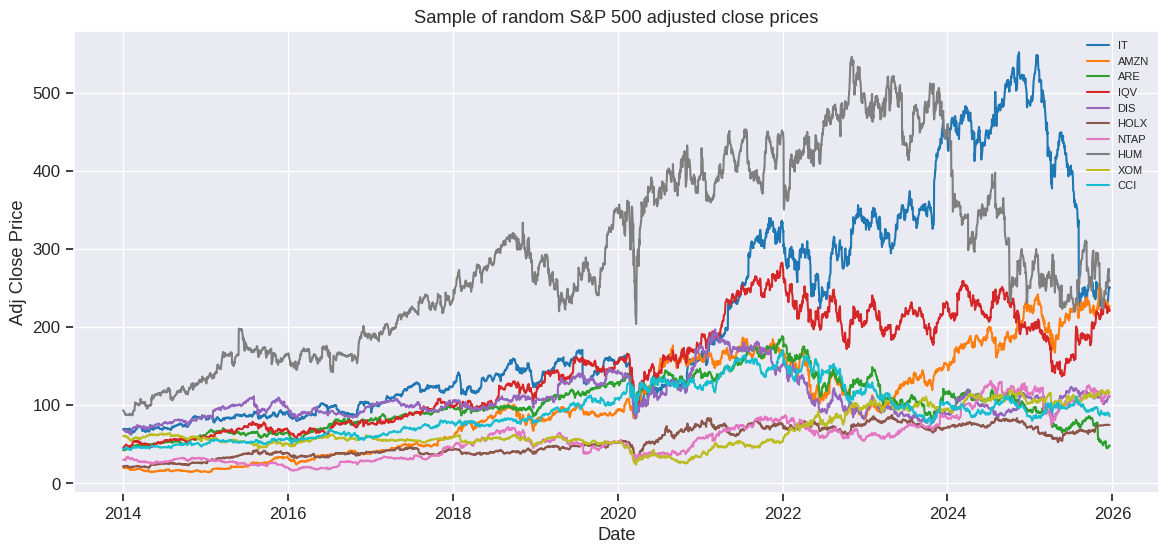

In [5]:
# 4A. QUICK EDA ON CLEANED DATA

print("Date range:", data.index.min(), "→", data.index.max())
print("Number of assets:", data.shape[1])

display(data.describe().T.head())

# Sample of 10 random tickers
sample_cols = np.random.choice(data.columns, size=min(10, data.shape[1]), replace=False)

plt.figure(figsize=(14, 6))
plt.plot(data.index, data[sample_cols])
plt.title("Sample of random S&P 500 adjusted close prices")
plt.xlabel("Date")
plt.ylabel("Adj Close Price")
plt.legend(sample_cols, fontsize=8)
plt.show()

# Daily returns for correlation analysis
returns = data.pct_change().dropna()




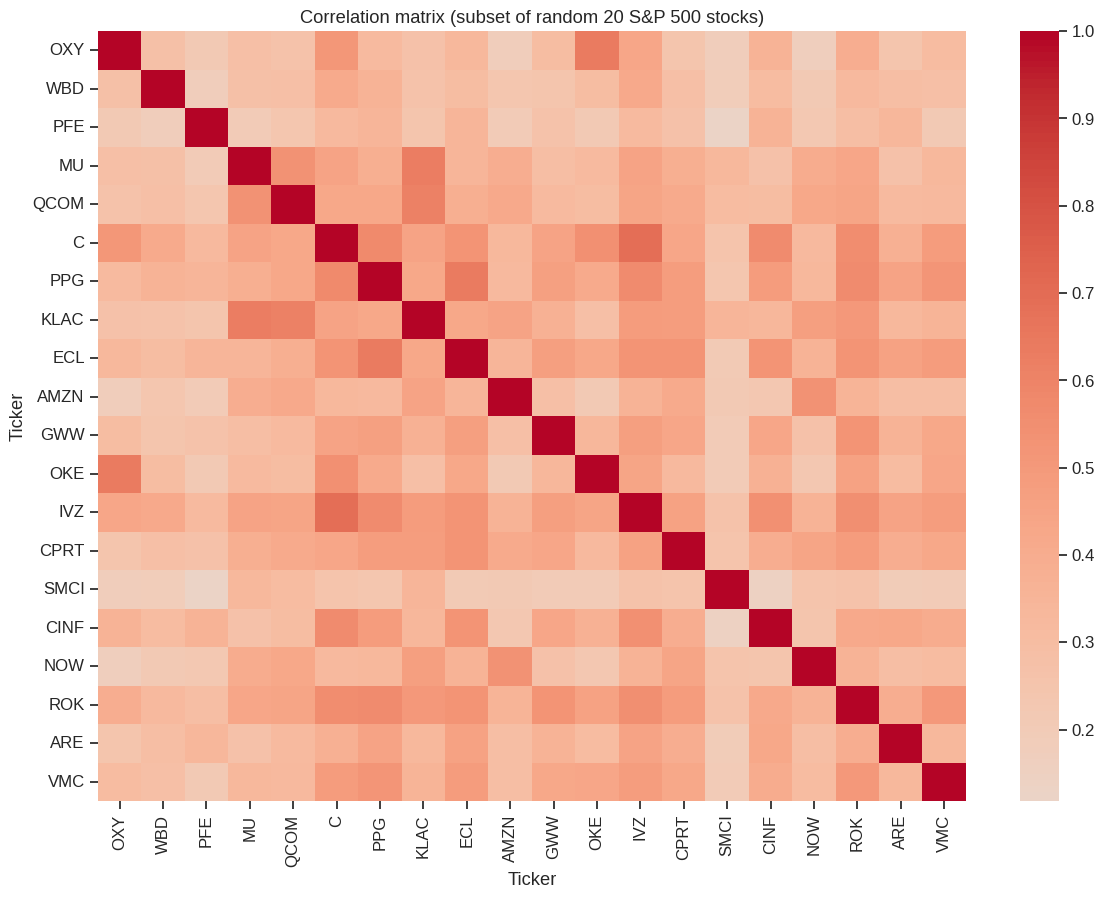

In [6]:
# 4B. CLEAN HEATMAP ON A SUBSET OF 20 TICKERS

subset_cols = np.random.choice(returns.columns, 20, replace=False)
subset = returns[subset_cols]

plt.figure(figsize=(14, 10))
sns.heatmap(subset.corr(), cmap="coolwarm", center=0)
plt.title("Correlation matrix (subset of random 20 S&P 500 stocks)")
plt.show()


In [7]:
# 5. PAIR SELECTION

# Error we made : using returns.corr() on the full history would cause Data Leakage.

train_ratio = 0.7
split_idx = int(len(returns) * train_ratio)

returns_train = returns.iloc[:split_idx]

print(f"Computing the correlation matrix on {len(returns_train)} days (Train set)...")
corr_matrix = returns_train.corr()

strong_pairs = []
threshold = 0.75

cols = corr_matrix.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):   # i < j to avoid (A,B) and (B,A)
        ti = cols[i]
        tj = cols[j]

        rho = corr_matrix.iloc[i, j]

        if rho >= threshold:
            strong_pairs.append((ti, tj, rho))

# Sort by descending correlation
strong_pairs_sorted = sorted(strong_pairs, key=lambda x: x[2], reverse=True)

print(f"Number of pairs with corr >= {threshold} (on Train): {len(strong_pairs_sorted)}")
print("Top 20 candidate pairs:")
for p in strong_pairs_sorted[:20]:
    print(p)


Computing the correlation matrix on 2107 days (Train set)...
Number of pairs with corr >= 0.75 (on Train): 524
Top 20 candidate pairs:
('GOOG', 'GOOGL', np.float64(0.9921846636258408))
('NWS', 'NWSA', np.float64(0.9703773591191255))
('KEY', 'RF', np.float64(0.9217450929848559))
('FRT', 'REG', np.float64(0.9186730866759654))
('FITB', 'KEY', np.float64(0.9130472407247513))
('FITB', 'RF', np.float64(0.9129640895393369))
('MET', 'PRU', np.float64(0.9123390066672319))
('EQR', 'UDR', np.float64(0.9108433094707581))
('BAC', 'JPM', np.float64(0.9084358897808797))
('AVB', 'EQR', np.float64(0.9063572105719713))
('CMS', 'XEL', np.float64(0.9059216121175703))
('AVB', 'UDR', np.float64(0.9009199750303124))
('FITB', 'TFC', np.float64(0.8988928246044149))
('PNC', 'TFC', np.float64(0.8982929710542141))
('ESS', 'UDR', np.float64(0.8975803057702074))
('CMS', 'LNT', np.float64(0.8956941639361475))
('MA', 'V', np.float64(0.8922101527116587))
('TFC', 'USB', np.float64(0.891364213928313))
('KEY', 'PNC', np.

In [8]:
# 6. FILTERING AND CONSTRUCTION OF THE POOL

filtered_pairs = []

def is_same_company(t1, t2):
    # If the first 3 letters are identical, we assume the same company.
    return t1[:3] == t2[:3]

print("Removing duplicates (same company)...")

for t1, t2, rho in strong_pairs_sorted:
    # 1. Reject if it is the same company (arbitrage/not pairs trading)
    if is_same_company(t1, t2):
        continue

    filtered_pairs.append((t1, t2, rho))

top_candidates = filtered_pairs[:200]

# Create a DataFrame for verification
df_candidates = pd.DataFrame(top_candidates, columns=["Asset_A", "Asset_B", "Correlation"])

print(f"\nCandidates retained for screening: {len(df_candidates)}")
print("Preview of Top 15 (very strong correlations):")
print(df_candidates.head(15).to_string(index=False))

print("\n... Preview of the bottom of the ranking (weaker correlations, ML target):")
print(df_candidates.tail(5).to_string(index=False))

pairs_to_test = top_candidates


Removing duplicates (same company)...

Candidates retained for screening: 200
Preview of Top 15 (very strong correlations):
Asset_A Asset_B  Correlation
    KEY      RF       0.9217
    FRT     REG       0.9187
   FITB     KEY       0.9130
   FITB      RF       0.9130
    MET     PRU       0.9123
    EQR     UDR       0.9108
    BAC     JPM       0.9084
    AVB     EQR       0.9064
    CMS     XEL       0.9059
    AVB     UDR       0.9009
   FITB     TFC       0.8989
    PNC     TFC       0.8983
    ESS     UDR       0.8976
    CMS     LNT       0.8957
     MA       V       0.8922

... Preview of the bottom of the ranking (weaker correlations, ML target):
Asset_A Asset_B  Correlation
    DOC    WELL       0.8073
    AEE      ED       0.8072
    AEE      SO       0.8071
    CMS     ETR       0.8070
    BXP     FRT       0.8068


Statistical analysis on 200 pairs...
Calibration on the Train Set (up to 2022-05-16)

=== PAIR KEY - RF (Corr=0.92 | P-val=0.0201) ===


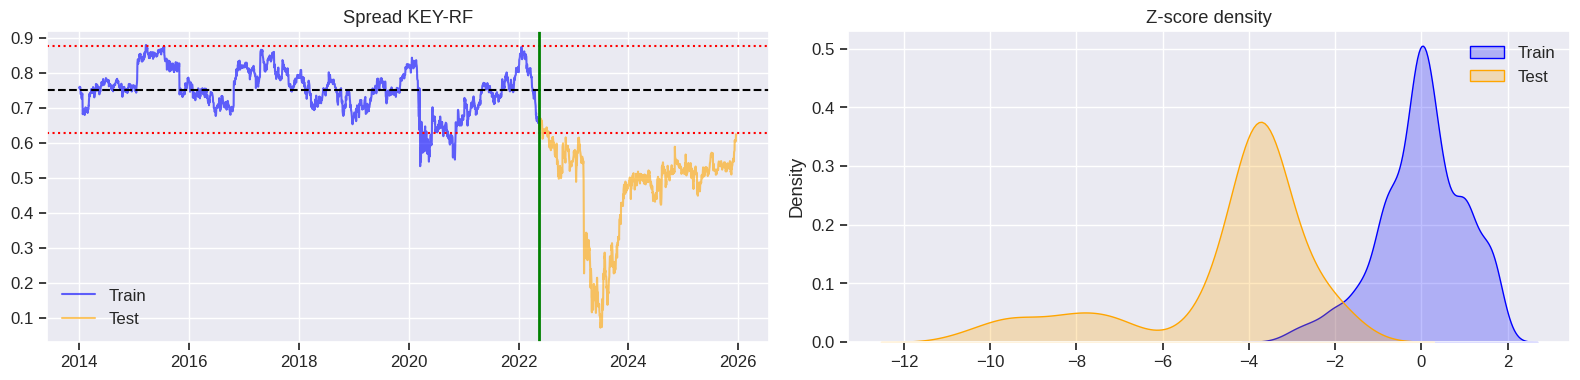

=== PAIR FRT - REG (Corr=0.92 | P-val=0.5848) ===


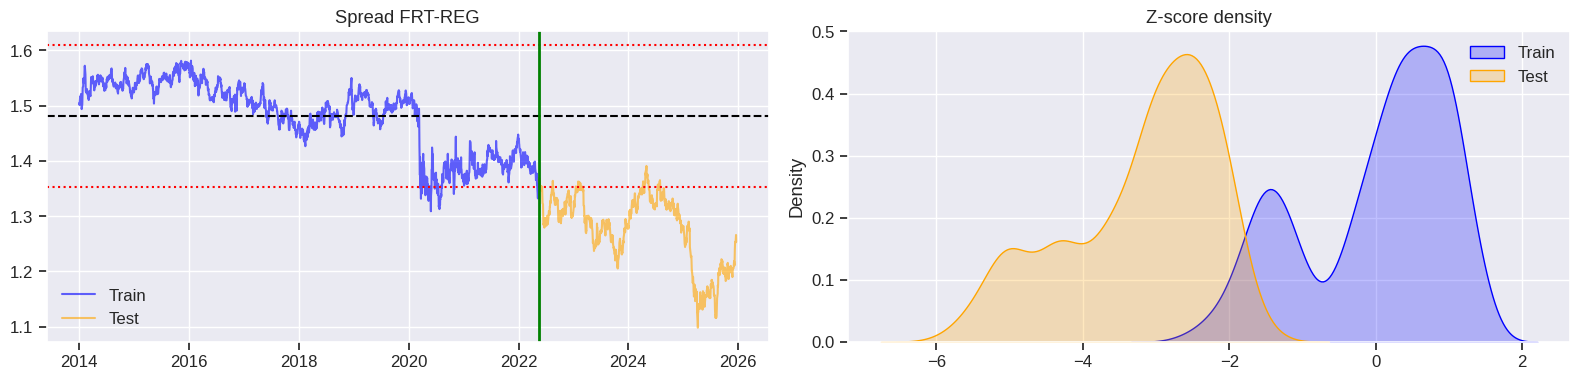

=== PAIR FITB - KEY (Corr=0.91 | P-val=0.0664) ===


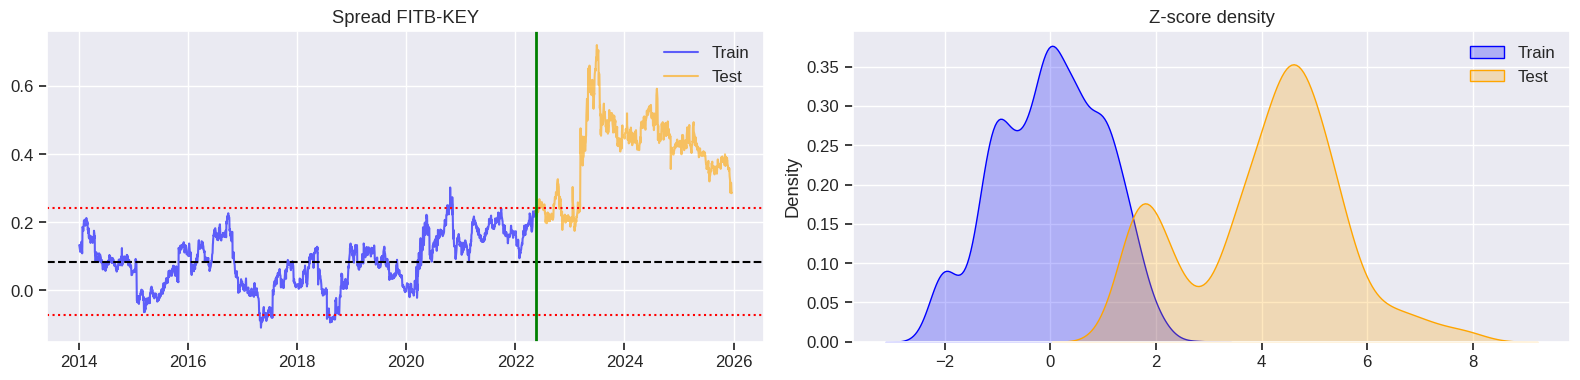

=== PAIR FITB - RF (Corr=0.91 | P-val=0.0334) ===


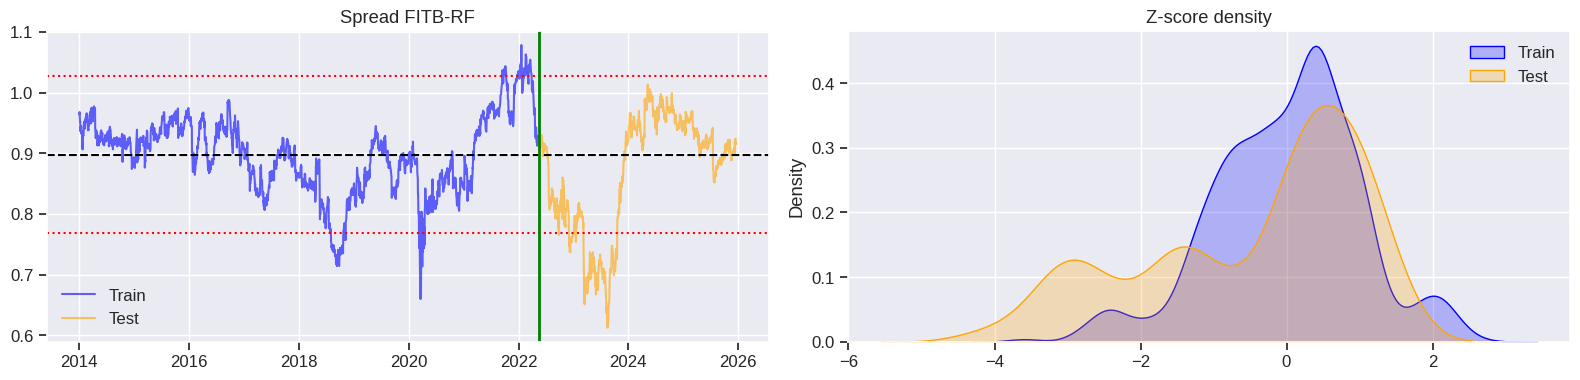

=== PAIR MET - PRU (Corr=0.91 | P-val=0.5519) ===


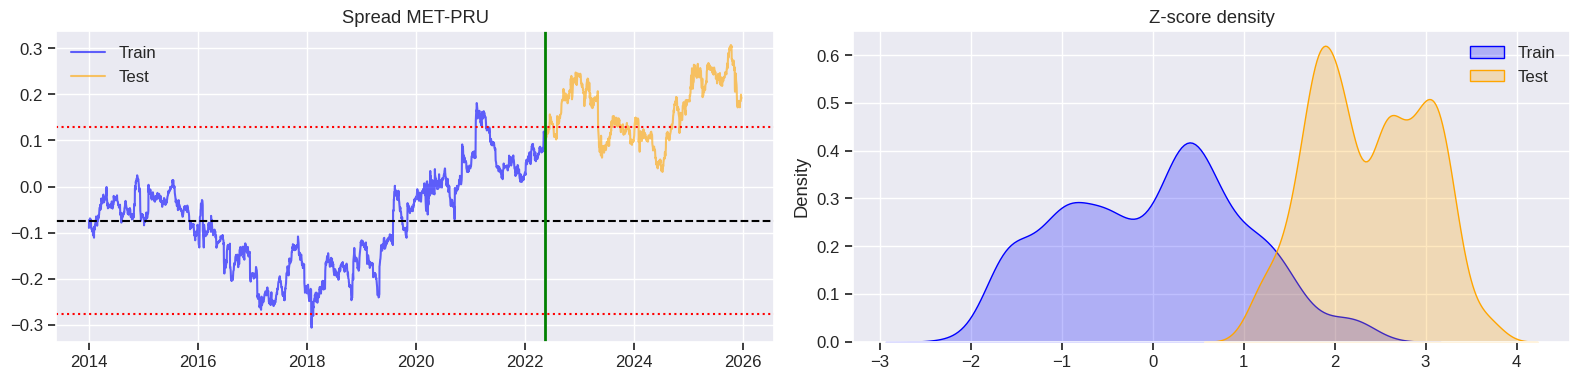

Analysis completed. 200 pairs processed.
Ready for zone visualization (Step 7b).


In [9]:
# 7.A SPREAD & COINTEGRATION ANALYSIS
from statsmodels.tsa.stattools import adfuller

eda_results = []

candidates = pairs_to_test if 'pairs_to_test' in globals() else []

train_limit = int(len(data) * 0.7)
train_date_limit = data.index[train_limit]

print(f"Statistical analysis on {len(candidates)} pairs...")
print(f"Calibration on the Train Set (up to {train_date_limit.date()})\n")

plot_counter = 0

for (A, B, corr) in candidates:

    # 1. Data extraction
    if A not in data.columns or B not in data.columns:
        continue
    df_pair = data[[A, B]].copy()

    # Log transformation
    df_pair[f"log_{A}"] = np.log(df_pair[A])
    df_pair[f"log_{B}"] = np.log(df_pair[B])

    # 2. Train / Test Split
    train = df_pair.iloc[:train_limit]
    test = df_pair.iloc[train_limit:]

    # 3. Beta on Train
    try:
        beta = np.polyfit(train[f"log_{B}"], train[f"log_{A}"], 1)[0]
    except:
        continue

    # 4. Spread Construction
    spread = df_pair[f"log_{A}"] - beta * df_pair[f"log_{B}"]

    spread_train = spread.iloc[:train_limit]
    spread_test = spread.iloc[train_limit:]

    # 5. Statistics (on Train)
    mean_sp = spread_train.mean()
    std_sp = spread_train.std()

    # ADF test
    adf_result = adfuller(spread_train.dropna())
    adf_pvalue = adf_result[1]

    # Half-life ---> Done with AI
    spread_lag = spread_train.shift(1).dropna()
    delta_spread = spread_train.diff().dropna()
    try:
        res_hl = np.polyfit(spread_lag, delta_spread, 1)
        theta = -res_hl[0]
        half_life = np.log(2) / theta if theta > 0 else 999
    except:
        half_life = 999

    # 6. VISUALIZATION --> Done with AI
    if plot_counter < 5:
        print(f"=== PAIR {A} - {B} (Corr={corr:.2f} | P-val={adf_pvalue:.4f}) ===")

        fig, axes = plt.subplots(1, 2, figsize=(16, 4))

        # Plot 1: Spread
        axes[0].plot(spread_train.index, spread_train, label="Train", color="blue", alpha=0.6)
        axes[0].plot(spread_test.index, spread_test, label="Test", color="orange", alpha=0.6)
        axes[0].axhline(mean_sp, color="black", linestyle="--")
        axes[0].axhline(mean_sp + 2 * std_sp, color="red", linestyle=":")
        axes[0].axhline(mean_sp - 2 * std_sp, color="red", linestyle=":")
        axes[0].axvline(train_date_limit, color="green", linewidth=2)
        axes[0].set_title(f"Spread {A}-{B}")
        axes[0].legend()

        # Plot 2: Z-score distribution
        z_train = (spread_train - mean_sp) / std_sp
        z_test = (spread_test - mean_sp) / std_sp
        sns.kdeplot(z_train, ax=axes[1], fill=True, label="Train", color="blue")
        sns.kdeplot(z_test, ax=axes[1], fill=True, label="Test", color="orange")
        axes[1].set_title("Z-score density")
        axes[1].legend()

        plt.tight_layout()
        plt.show()
        plot_counter += 1

    # 7. Storage
    eda_results.append({
        "Asset_A": A,
        "Asset_B": B,
        "Correlation": corr,
        "Beta": beta,
        "ADF_pvalue": adf_pvalue,
        "Half_Life": half_life,
        "Mean_Spread_Train": mean_sp,
        "Std_Spread_Train": std_sp
    })

df_results = pd.DataFrame(eda_results)
print(f"Analysis completed. {len(df_results)} pairs processed.")
print("Ready for zone visualization (Step 7b).")


Analysis on 200 pairs. Top 5 stationary pairs:


,Asset_A,Asset_B,Correlation,ADF_pvalue
12,ESS,UDR,0.8976,0.0003
37,ES,WEC,0.8752,0.0003
188,RJF,SCHW,0.8090,0.0004
142,CDNS,SNPS,0.8273,0.0007
165,BAC,NTRS,0.8172,0.0013


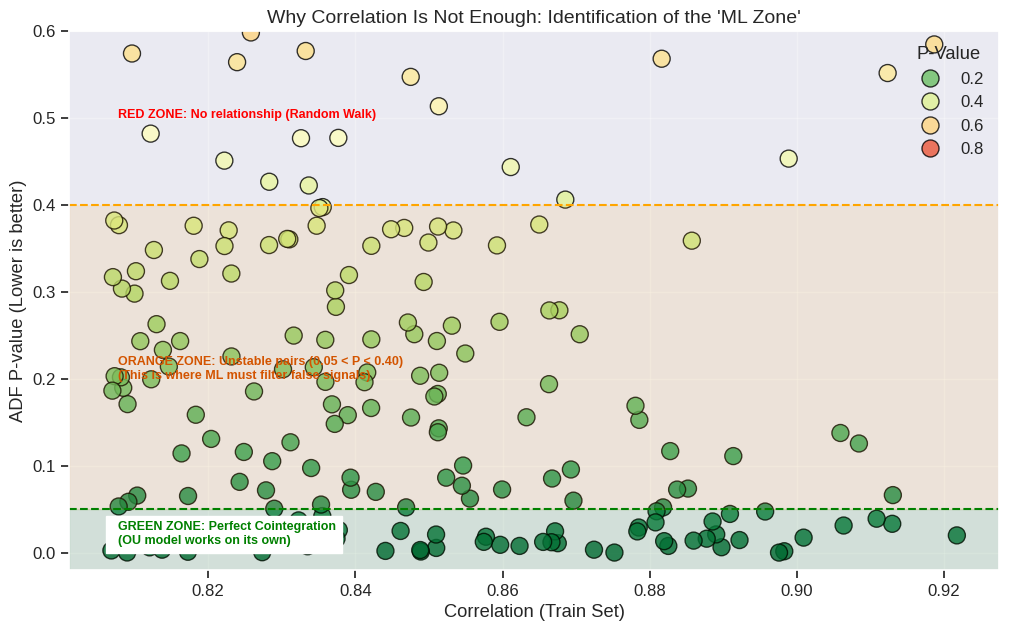

CHART INTERPRETATION:
1. GREEN points (<0.05) are the safe pairs.
2. ORANGE points (0.05 - 0.40) are the traps we will exploit.


In [10]:
# 7.B DIAGNOSTIC ANALYSIS: CORRELATION vs COINTEGRATION

# Safety check: retrieve available data (either from EDA or final screening)
if 'eda_results' in globals() and eda_results:
    eda_df = pd.DataFrame(eda_results)
elif 'df_final_pairs' in globals() and not df_final_pairs.empty:
  eda_df = df_final_pairs.copy()
else:
  # Case where nothing has been run yet
  print("No pair data available to display at the moment.")
  eda_df = pd.DataFrame()

if not eda_df.empty:
    # Cleaning and sorting
    eda_df_sorted = eda_df.sort_values("ADF_pvalue")

    print(f"Analysis on {len(eda_df)} pairs. Top 5 stationary pairs:")
    display(eda_df_sorted[["Asset_A", "Asset_B", "Correlation", "ADF_pvalue"]].head(5))

    # ==============================================================================
    # CRUCIAL CHART: THE 3 PROJECT ZONES (DONE WITH AI)
    # ==============================================================================

    plt.figure(figsize=(12, 7))

    # Scatter plot
    sns.scatterplot(
        data=eda_df,
        x="Correlation",
        y="ADF_pvalue",
        hue="ADF_pvalue",
        palette="RdYlGn_r",  # Green (0) -> Red (1)
        s=150,
        edgecolor="black",
        alpha=0.8
    )

    # Axis limits to clearly visualize the zones
    # Zoom on the region of interest (0 to 0.6)
    plt.ylim(-0.02, 0.60)
    min_corr = eda_df["Correlation"].min() if len(eda_df) > 0 else 0.80

    # --- ZONE 1: EASY PROFITS (OR CLASSICAL) ---
    plt.axhline(0.05, color="green", linestyle="--", linewidth=1.5)
    plt.axhspan(-0.02, 0.05, color='green', alpha=0.1)
    plt.text(
        min_corr, 0.01,
        "  GREEN ZONE: Perfect Cointegration\n  (OU model works on its own)",
        color="green", fontweight="bold", fontsize=9, backgroundcolor="white"
    )

    # --- ZONE 2: THE ML PLAYGROUND (DIRTY PAIRS) ---
    plt.axhline(0.40, color="orange", linestyle="--", linewidth=1.5)
    plt.axhspan(0.05, 0.40, color='orange', alpha=0.1)
    plt.text(
        min_corr, 0.20,
        "  ORANGE ZONE: Unstable pairs (0.05 < P < 0.40)\n"
        "  (This is where ML must filter false signals)",
        color="#D35400", fontweight="bold", fontsize=9
    )

    # --- ZONE 3: DANGER (RANDOM WALK) ---
    plt.text(
        min_corr, 0.50,
        "  RED ZONE: No relationship (Random Walk)",
        color="red", fontweight="bold", fontsize=9
    )

    plt.title(
        "Why Correlation Is Not Enough: Identification of the 'ML Zone'",
        fontsize=14
    )
    plt.xlabel("Correlation (Train Set)")
    plt.ylabel("ADF P-value (Lower is better)")
    plt.legend(title="P-Value", loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.show()

    print("CHART INTERPRETATION:")
    print("1. GREEN points (<0.05) are the safe pairs.")
    print("2. ORANGE points (0.05 - 0.40) are the traps we will exploit.")


In [11]:
# 8. "DIRTY" SELECTION (FORCING A MIX OF GOOD/BAD PAIRS)

final_pairs = []

# --- 1. EXPANDING THE CANDIDATE POOL ---
# We take a wide spectrum of candidates (top 150 correlations)
# This ensures we capture pairs that "drift" (Orange Zone)
if 'filtered_pairs' in globals():
    candidates = filtered_pairs[:150]
elif 'strong_pairs_sorted' in globals():
    candidates = strong_pairs_sorted[:150]
else:
    # Fallback if no list exists (use available tickers)
    cols = data.columns[:20]
    candidates = [(cols[i], cols[j], 0.9) for i in range(len(cols)) for j in range(i + 1, len(cols))]

print(f"🔬 Strategic screening on {len(candidates)} candidates...")
print("   (Searching for both 'Easy' AND 'Difficult' pairs for ML)\n")

count_tested = 0
for A, B, corr in candidates:
    if A not in data.columns or B not in data.columns:
        continue

    # Log prices
    logA = np.log(data[A])
    logB = np.log(data[B])

    # ADF test on TRAIN (70%)
    # We only look at the past to decide, as in real trading
    split = int(len(logA) * 0.7)

    # Optimization: if too short, skip
    if split < 500:
        continue

    # Beta and Spread
    try:
        beta = np.polyfit(logB.iloc[:split], logA.iloc[:split], 1)[0]
        spread = logA - beta * logB
        spread_train = spread.iloc[:split].dropna()

        # Stationarity test
        p_val = adfuller(spread_train)[1]

        # Keep everything below 0.40 (Green + Orange)
        # Reject Red (> 0.40) as it is impossible to trade
        if p_val < 0.40:
            final_pairs.append({
                "Asset_A": A,
                "Asset_B": B,
                "ADF_pvalue": p_val,
                "Correlation": corr
            })
        count_tested += 1

    except:
        continue

df_all = pd.DataFrame(final_pairs)

if df_all.empty:
    print("ERROR: No pair found with p-value < 0.40. Check your data.")
else:
    # --- 2. FORCED MIX (50% GREEN / 50% ORANGE) ---

    # “Top students” (Green Zone < 0.05)
    df_green = df_all[df_all["ADF_pvalue"] < 0.05].sample(frac=1, random_state=42)

    # “Underperformers” (Orange Zone 0.05 - 0.40) → ML must handle them
    df_orange = df_all[df_all["ADF_pvalue"] >= 0.05].sample(frac=1, random_state=42)

    print(f"Candidate pool found: {len(df_green)} Safe pairs (Green) vs {len(df_orange)} Unstable pairs (Orange).")

    # Build the final portfolio (max 10 of each for balance)
    # If not enough Oranges, take all available
    n_green = min(12, len(df_green))
    n_orange = min(12, len(df_orange))

    df_final_pairs = pd.concat([
        df_green.head(n_green),
        df_orange.head(n_orange)
    ])

    # Final shuffle to avoid order bias
    df_final_pairs = df_final_pairs.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\nSELECTION COMPLETED: {len(df_final_pairs)} pairs retained.")
    print(f"   Composition: {n_green} Easy (Green) + {n_orange} Difficult (Orange).")

    # Preview
    print("\nPreview of the mix (note the heterogeneous p-values):")
    print(df_final_pairs[["Asset_A", "Asset_B", "ADF_pvalue", "Correlation"]].head(10).to_string(index=False))

    # Bonus: update eda_results so that rerunning Step 7 updates the plots
    eda_results = df_final_pairs.to_dict('records')


🔬 Strategic screening on 150 candidates...
   (Searching for both 'Easy' AND 'Difficult' pairs for ML)

Candidate pool found: 45 Safe pairs (Green) vs 80 Unstable pairs (Orange).

SELECTION COMPLETED: 24 pairs retained.
   Composition: 12 Easy (Green) + 12 Difficult (Orange).

Preview of the mix (note the heterogeneous p-values):
Asset_A Asset_B  ADF_pvalue  Correlation
     MA       V      0.0147       0.8922
    MTB     TFC      0.3777       0.8650
      C     PNC      0.0423       0.8355
    JPM     PNC      0.1692       0.8781
    AEE     LNT      0.0248       0.8671
    AVB     EQR      0.0314       0.9064
   FITB     KEY      0.0664       0.9130
   HBAN     TFC      0.0122       0.8667
    LNT     WEC      0.0601       0.8696
    AMP     MET      0.0162       0.8330


In [12]:
# 9. ML DATASET PREPARATION (ADVANCED FEATURES + LOOK-AHEAD PROTECTION)

def build_dataset_for_pair(asset_a, asset_b, H=30, window_mu=60, vol_window=20):
    """
    Builds the ML dataset for an A-B pair using a rigorous methodology.
    """

    if asset_a not in data.columns or asset_b not in data.columns:
        return pd.DataFrame()

    df_pair = data[[asset_a, asset_b]].dropna()


    if len(df_pair) < window_mu + H + 100:
        return pd.DataFrame()


    logA = np.log(df_pair[asset_a])
    logB = np.log(df_pair[asset_b])



    split_idx = int(len(df_pair) * 0.7)
    train_logA = logA.iloc[:split_idx]
    train_logB = logB.iloc[:split_idx]

    beta = np.polyfit(train_logB, train_logA, 1)[0]

    spread = logA - beta * logB
    spread.name = "spread"

    mu_roll = spread.rolling(window_mu).mean()
    sigma_roll = spread.rolling(window_mu).std()
    zscore = (spread - mu_roll) / sigma_roll


    # FEATURE ENGINEERING



    spread_diff = spread.diff()
    slope_5 = spread_diff.rolling(5).mean()
    slope_10 = spread_diff.rolling(10).mean()


    mr_speed = spread - spread.shift(5)


    acc_3 = spread_diff.diff().rolling(3).mean()


    abs_diff = spread_diff.abs()
    mean_abs_diff_20 = abs_diff.rolling(20).mean()
    jump = (abs_diff > 1.5 * mean_abs_diff_20).astype(int)


    spread_vol = spread.rolling(vol_window).std()
    skew_20 = spread.rolling(20).skew()
    kurt_20 = spread.rolling(20).kurt()

    try:
        if 'returns' in globals():
            retA = returns[asset_a].reindex(spread.index)
            retB = returns[asset_b].reindex(spread.index)
            vol_A = retA.rolling(20).std()
            vol_B = retB.rolling(20).std()
            vol_ratio = vol_A / vol_B
        else:
            vol_ratio = pd.Series(0, index=spread.index)
    except:
        vol_ratio = pd.Series(0, index=spread.index)




    future_spread = spread.shift(-H)
    future_return = future_spread - spread



    ou_pnl = -np.sign(zscore) * future_return


    y = (ou_pnl > 0).astype(int)




    features = pd.DataFrame({
        "zscore": zscore,
        "spread_vol": spread_vol,
        "slope_5": slope_5,
        "slope_10": slope_10,
        "mr_speed": mr_speed,
        "acc_3": acc_3,
        "jump": jump,
        "skew_20": skew_20,
        "kurt_20": kurt_20,
        "vol_ratio": vol_ratio,

        "spread": spread
    })


    features = features.shift(1)

    df_final = features.copy()
    df_final["y"] = y
    df_final["ou_pnl"] = ou_pnl
    df_final["pair"] = f"{asset_a}-{asset_b}"

    # Drop NaNs (from rolling windows and shifting)
    df_final = df_final.dropna()

    return df_final


In [13]:

# 10. GLOBAL DATASET CONSTRUCTION (MIXED DATASET)


# 1. Retrieve the dirty  selection
if 'df_final_pairs' not in globals() or df_final_pairs.empty:
    raise ValueError("ERROR: Run step 8 first!")



# We take ALL pairs selected in step 8 (Green + Orange mix).
pairs_for_ml = list(zip(df_final_pairs["Asset_A"], df_final_pairs["Asset_B"]))

print(f"Pipeline: Building the dataset on {len(pairs_for_ml)} pairs (Mixed Easy/Difficult).")

# 2. Dataset construction
# We stick with H=35
BEST_H = 35
datasets = []

print(f"\nBuilding the Multi-Asset dataset (H={BEST_H} days)...")

for A, B in pairs_for_ml:
    # Call the build_dataset_for_pair function (Step 9)
    df_pair = build_dataset_for_pair(A, B, H=BEST_H)

    if len(df_pair) > 0:
        datasets.append(df_pair)

# 3. Aggregation
if len(datasets) > 0:
    df_ml = pd.concat(datasets, axis=0)

    #  chronological sorting
    df_ml = df_ml.sort_index()

    print(f"\nML dataset assembled: {df_ml.shape}")
    print(f"   Period: {df_ml.index.min().date()} -> {df_ml.index.max().date()}")

    # 4. Label checks
    distrib = df_ml["y"].value_counts(normalize=True)
    print(f"\nClass distribution (Target):\n{distrib}")

    # Preview
    display(df_ml.head())

else:
    print("ERROR: The datasets are empty.")


Pipeline: Building the dataset on 24 pairs (Mixed Easy/Difficult).

Building the Multi-Asset dataset (H=35 days)...

ML dataset assembled: (69984, 14)
   Period: 2014-03-31 -> 2025-10-30

Class distribution (Target):
y
1   0.5356
0   0.4644
Name: proportion, dtype: float64


,zscore,spread_vol,slope_5,slope_10,mr_speed,acc_3,jump,skew_20,kurt_20,vol_ratio,spread,y,ou_pnl,pair
Date,,,,,,,,,,,,,,
2014-03-31,-0.3083,0.0099,0.0046,0.0005,0.0229,0.0112,1.0000,0.0508,-0.0699,1.2779,-0.2797,1,0.0286,MA-V
2014-03-31,-0.2606,0.0101,0.0012,-0.0005,0.0059,0.0051,0.0000,-0.0793,0.8621,1.0167,-1.4736,1,0.0235,PNC-USB
2014-03-31,0.9201,0.0062,0.0002,0.0008,0.0012,-0.0001,0.0000,-0.2658,-0.8475,0.9716,2.3383,0,-0.0079,MTB-PNC
2014-03-31,1.7763,0.0102,-0.0008,0.0018,-0.0039,0.0002,0.0000,0.6095,-0.7452,1.0289,2.2309,1,0.0169,ESS-UDR
2014-03-31,1.2376,0.0149,-0.0046,0.0012,-0.0229,0.0004,0.0000,-0.0576,-0.3747,1.2779,0.5501,0,-0.0065,MCO-SPGI


In [14]:

# 11. ROBUST TEMPORAL SPLIT (TRAIN / TEST)



# Ensure that data is sorted by Date, otherwise a 70% split makes no temporal sense.
df_ml = df_ml.sort_index()

# 2. Feature (X) and Target (y) selection
# Remove 'spread' because it is a raw non-stationary value
# The model must learn only from normalized values
cols_to_drop = ["y", "pair", "ou_pnl", "future_return", "spread"]

# Filter to avoid errors if a column is missing
existing_cols_to_drop = [c for c in cols_to_drop if c in df_ml.columns]

X = df_ml.drop(columns=existing_cols_to_drop)
y = df_ml["y"]

# 3. Split (70% Train / 30% Test)
split_idx = int(0.7 * len(df_ml))
split_date = df_ml.index[split_idx]

print(f"Split Index: {split_idx}")
print(f"Cutoff Date: {split_date.date()}")

# Create subsets
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Keep full DataFrames (for pnl backtesting later)
df_train = df_ml.iloc[:split_idx].copy()
df_test  = df_ml.iloc[split_idx:].copy()

print("-" * 30)
print(f"X_train shape: {X_train.shape} (Data up to {df_train.index.max().date()})")
print(f"X_test shape : {X_test.shape} (Data from {df_test.index.min().date()})")
print(f"Features used ({len(X.columns)}): {list(X.columns)}")


Split Index: 48988
Cutoff Date: 2022-05-06
------------------------------
X_train shape: (48988, 10) (Data up to 2022-05-06)
X_test shape : (20996, 10) (Data from 2022-05-06)
Features used (10): ['zscore', 'spread_vol', 'slope_5', 'slope_10', 'mr_speed', 'acc_3', 'jump', 'skew_20', 'kurt_20', 'vol_ratio']


Training Logistic Regression...

=== LOGISTIC REGRESSION RESULTS ===
Accuracy : 51.34%
AUC Score: 0.5138

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.54      0.51      9723
           1       0.55      0.49      0.52     11273

    accuracy                           0.51     20996
   macro avg       0.51      0.52      0.51     20996
weighted avg       0.52      0.51      0.51     20996



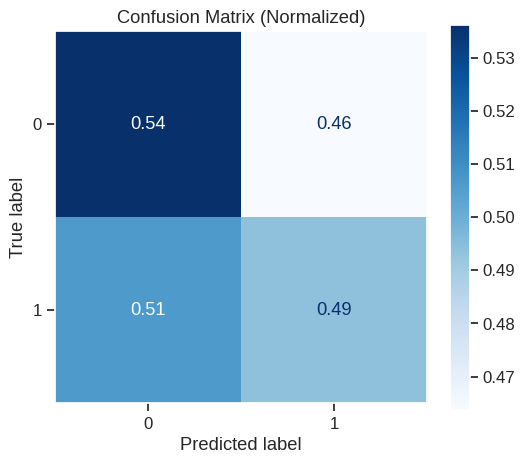

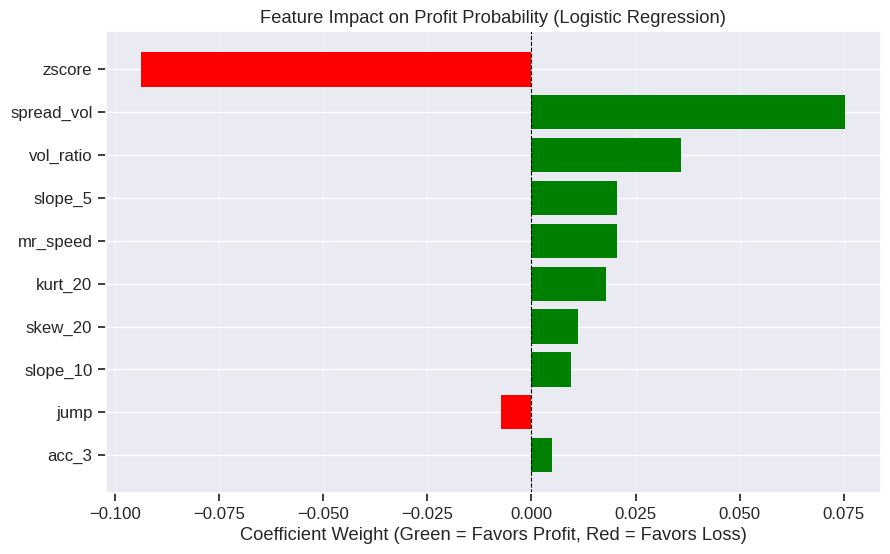

Interpretation:
- GREEN bar: a high value of this feature increases the probability of success.
- RED bar: a high value decreases the probability (indicates risk).


In [15]:
# 12.A BASELINE: LOGISTIC REGRESSION (WITH INTERPRETATION)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

# 1. Model configuration
pipe_logit = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(
        class_weight="balanced",
        C=100,
        max_iter=1000,
        random_state=42
    ))
])

# 2. Training
print("Training Logistic Regression...")
pipe_logit.fit(X_train, y_train)

# 3. Predictions
y_pred = pipe_logit.predict(X_test)
y_prob = pipe_logit.predict_proba(X_test)[:, 1]

# 4. Performance metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\n=== LOGISTIC REGRESSION RESULTS ===")
print(f"Accuracy : {acc:.2%}")
print(f"AUC Score: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 5. VISUALIZATION 1: Confusion Matrix
# Helps visualize False Positives vs True Positives
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(
    pipe_logit, X_test, y_test,
    cmap="Blues", normalize='true', ax=plt.gca()
)
plt.title("Confusion Matrix (Normalized)")
plt.grid(False)
plt.show()

# 6. VISUALIZATION 2: Interpretability (Coefficients)
# This is the advantage of Logistic Regression: feature importance is explicit
coefs = pipe_logit.named_steps["logit"].coef_[0]
feature_names = X_train.columns

# Build DataFrame for sorting
df_coefs = pd.DataFrame({"Feature": feature_names, "Coefficient": coefs})
df_coefs["Abs_Coef"] = df_coefs["Coefficient"].abs()
df_coefs = df_coefs.sort_values("Abs_Coef", ascending=True)  # Sort for display

plt.figure(figsize=(10, 6))
plt.barh(
    df_coefs["Feature"],
    df_coefs["Coefficient"],
    color=np.where(df_coefs["Coefficient"] > 0, 'green', 'red')
)
plt.title("Feature Impact on Profit Probability (Logistic Regression)")
plt.xlabel("Coefficient Weight (Green = Favors Profit, Red = Favors Loss)")
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)
plt.grid(axis="x", alpha=0.3)
plt.show()

print("Interpretation:")
print("- GREEN bar: a high value of this feature increases the probability of success.")
print("- RED bar: a high value decreases the probability (indicates risk).")


Starting hyperparameter optimization (Logistic Regression)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

=== BEST PARAMETERS (LOGIT) ===
Best Params : {'logit__C': 0.001, 'logit__penalty': 'l2', 'logit__solver': 'lbfgs'}
Best CV Score (AUC) : 0.5221


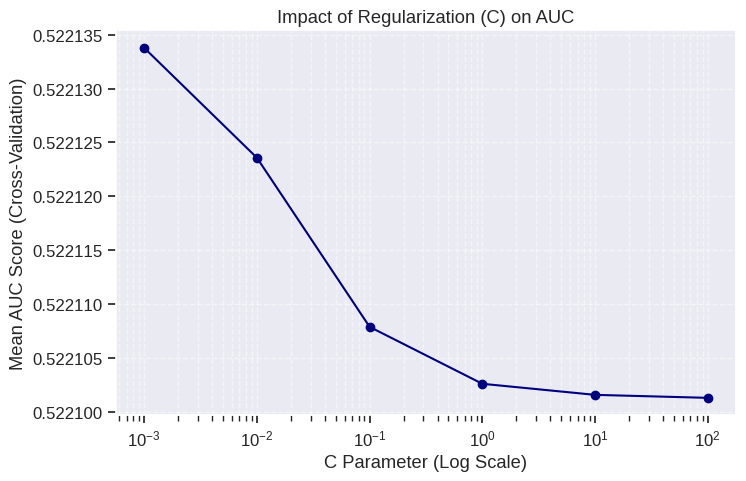


=== PERFORMANCE ON TEST SET (AFTER OPTIMIZATION) ===
Accuracy : 51.24%
AUC Score: 0.5133

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.54      0.51      9723
           1       0.55      0.49      0.52     11273

    accuracy                           0.51     20996
   macro avg       0.51      0.51      0.51     20996
weighted avg       0.52      0.51      0.51     20996



In [16]:
# 12.B OPTIMIZATION: GRID SEARCH ON LOGISTIC REGRESSION

print("Starting hyperparameter optimization (Logistic Regression)...")

# 1. Temporal Cross-Validation configuration
# Important: TimeSeriesSplit prevents validation on the past (look-ahead bias)
tscv = TimeSeriesSplit(n_splits=5)

# 2. Hyperparameter grid to test
# Small C = Strong regularization (prevents memorization)
# Large C = Weak regularization (fits data closely)
param_grid = {
    "logit__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "logit__penalty": ["l2"],
    "logit__solver": ["lbfgs"]
}

# 3. Run the search
grid_logit = GridSearchCV(
    pipe_logit,         # Pipeline defined above
    param_grid,
    cv=tscv,            # Temporal cross-validation
    scoring="roc_auc",  # Optimize AUC (more relevant than accuracy in finance)
    n_jobs=-1,
    verbose=1           # Show progress
)

grid_logit.fit(X_train, y_train)

# 4. Results analysis
print("\n=== BEST PARAMETERS (LOGIT) ===")
print(f"Best Params : {grid_logit.best_params_}")
print(f"Best CV Score (AUC) : {grid_logit.best_score_:.4f}")

# 5. Visualization of C impact
results = pd.DataFrame(grid_logit.cv_results_)
plt.figure(figsize=(8, 5))
plt.plot(results["param_logit__C"], results["mean_test_score"], marker="o", color="navy")
plt.xscale("log")  # Log scale since C ranges from 0.001 to 100
plt.title("Impact of Regularization (C) on AUC")
plt.xlabel("C Parameter (Log Scale)")
plt.ylabel("Mean AUC Score (Cross-Validation)")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()

# 6. Champion evaluation on the Test Set
best_logit = grid_logit.best_estimator_

y_pred = best_logit.predict(X_test)
y_prob = best_logit.predict_proba(X_test)[:, 1]

acc_opt = accuracy_score(y_test, y_pred)
auc_opt = roc_auc_score(y_test, y_prob)

print("\n=== PERFORMANCE ON TEST SET (AFTER OPTIMIZATION) ===")
print(f"Accuracy : {acc_opt:.2%}")
print(f"AUC Score: {auc_opt:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


 Training Random Forest...

RANDOM FOREST RESULTS
AUC Train : 0.5805
AUC Test  : 0.5297
Gap       : 0.0507
Accuracy  : 52.21%


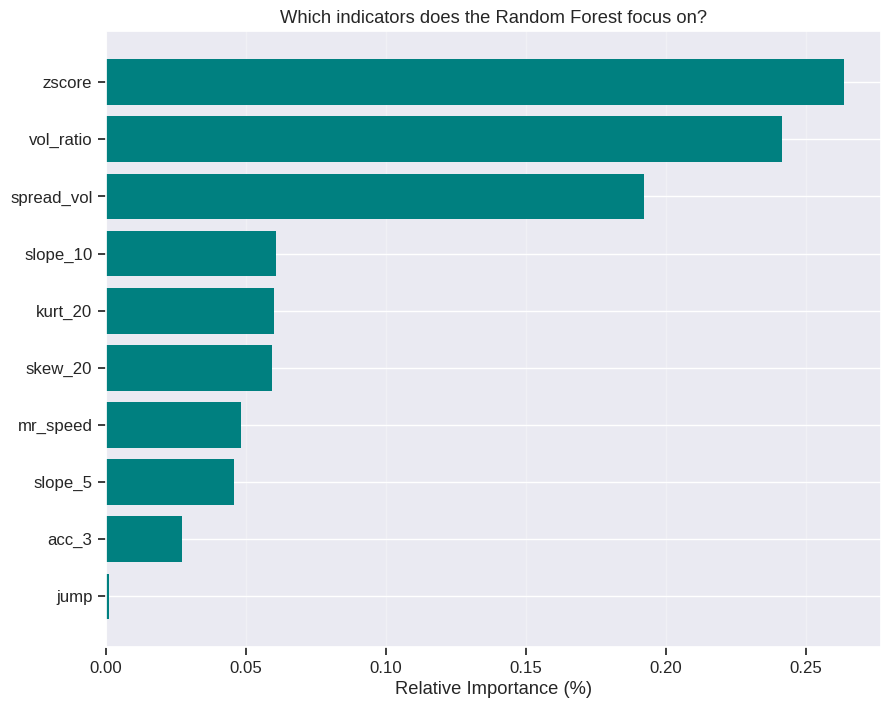

Analysis:
If Test AUC > 0.50, the Random Forest succeeded where Logistic Regression failed.
Check which features rank highest (Z-score? Volatility?).


In [17]:
# 13. ADVANCED MODEL: RANDOM FOREST (NON-LINEAR RESPONSE)

# 1. Random Forest configuration
# We use conservative hyperparameters to avoid memorization (overfitting)
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),  # Keeps consistency with other models
    ("rf", RandomForestClassifier(
        n_estimators=300,           # More trees to stabilize variance
        max_depth=5,                # LOW depth (crucial: prevents learning noise)
        min_samples_leaf=50,        # Requires strong evidence to validate a rule
        class_weight="balanced_subsample",  # Handles class imbalance more effectively
        random_state=42,
        n_jobs=-1
    ))
])

# 2. Training
print(" Training Random Forest...")
pipe_rf.fit(X_train, y_train)

# 3. Predictions (Train & Test to check overfitting)
y_prob_train_rf = pipe_rf.predict_proba(X_train)[:, 1]
y_prob_test_rf = pipe_rf.predict_proba(X_test)[:, 1]

y_pred_test_rf = pipe_rf.predict(X_test)

# 4. Scores
auc_train_rf = roc_auc_score(y_train, y_prob_train_rf)
auc_test_rf = roc_auc_score(y_test, y_prob_test_rf)
acc_test_rf = accuracy_score(y_test, y_pred_test_rf)

print(f"\nRANDOM FOREST RESULTS")
print(f"AUC Train : {auc_train_rf:.4f}")
print(f"AUC Test  : {auc_test_rf:.4f}")
print(f"Gap       : {auc_train_rf - auc_test_rf:.4f}")
print(f"Accuracy  : {acc_test_rf:.2%}")



# 5. FEATURE IMPORTANCE (Explanation for the jury)
# We want to know WHICH indicator actually generates profit
rf_model = pipe_rf.named_steps["rf"]
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Build DataFrame for plotting
df_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
df_imp = df_imp.sort_values("Importance", ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(df_imp["Feature"], df_imp["Importance"], color="teal")
plt.title("Which indicators does the Random Forest focus on?")
plt.xlabel("Relative Importance (%)")
plt.grid(axis="x", alpha=0.3)
plt.show()

print("Analysis:")
print("If Test AUC > 0.50, the Random Forest succeeded where Logistic Regression failed.")
print("Check which features rank highest (Z-score? Volatility?).")


Training Voting Classifier (Logit + RF)...

COMPARATIVE RESULTS (AUC)
1. Logistic Regression : 0.5133
2. Random Forest       : 0.5297
3. Voting Classifier   : 0.5225


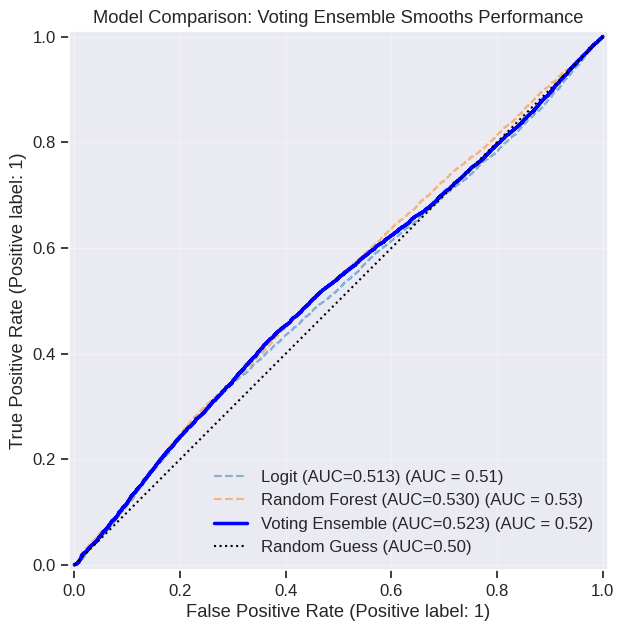

In [18]:
# 14. FINAL MODEL: VOTING CLASSIFIER & ROC CURVES

print("Training Voting Classifier (Logit + RF)...")

# 1. Definition and Training
# Combine Logistic Regression (cautious) with Random Forest (aggressive)
logit_estimator = grid_logit.best_estimator_ if 'grid_logit' in globals() else pipe_logit
rf_estimator = pipe_rf

voting_clf = VotingClassifier(
    estimators=[
        ('logit', logit_estimator),
        ('rf', rf_estimator)
    ],
    voting='soft',   # Average of predicted probabilities
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)

# 2. Compute probabilities for Test Set
y_prob_logit = logit_estimator.predict_proba(X_test)[:, 1]
y_prob_rf = rf_estimator.predict_proba(X_test)[:, 1]
y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]

# 3. AUC Scores
auc_logit = roc_auc_score(y_test, y_prob_logit)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_voting = roc_auc_score(y_test, y_prob_voting)

print(f"\nCOMPARATIVE RESULTS (AUC)")
print(f"1. Logistic Regression : {auc_logit:.4f}")
print(f"2. Random Forest       : {auc_rf:.4f}")
print(f"3. Voting Classifier   : {auc_voting:.4f}")

# 4. ROC PLOT (Visual proof for the report)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))

RocCurveDisplay.from_predictions(
    y_test, y_prob_logit, ax=ax,
    name=f"Logit (AUC={auc_logit:.3f})",
    alpha=0.5, linestyle='--'
)
RocCurveDisplay.from_predictions(
    y_test, y_prob_rf, ax=ax,
    name=f"Random Forest (AUC={auc_rf:.3f})",
    alpha=0.5, linestyle='--'
)
RocCurveDisplay.from_predictions(
    y_test, y_prob_voting, ax=ax,
    name=f"Voting Ensemble (AUC={auc_voting:.3f})",
    color='blue', linewidth=2.5
)

ax.plot([0, 1], [0, 1], 'k:', label="Random Guess (AUC=0.50)")
ax.set_title("Model Comparison: Voting Ensemble Smooths Performance")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")
plt.show()


In [19]:
# 15. FINAL CONFIGURATION & TRAINING (HORIZON H=45)

print("Initializing final configuration...")

# 1. Fixed parameters for the report
FINAL_H = 45
ML_AGRESSIVITY = 5.0
PROB_FLOOR = 0.505

# 2. Dataset reconstruction (if not already done for H=45)
print(f"   -> Building dataset with H={FINAL_H}...")
datasets_final = []

# Use the mixed pair list (Step 8)
if 'pairs_for_ml' in globals():
    for A, B in pairs_for_ml:
        df_pair = build_dataset_for_pair(A, B, H=FINAL_H)
        if len(df_pair) > 0:
            datasets_final.append(df_pair)
    df_final_ml = pd.concat(datasets_final).sort_index()
else:
    raise ValueError("The 'pairs_for_ml' list is empty. Rerun Step 8/10.")

# 3. Split & Training
split = int(0.7 * len(df_final_ml))
train_df = df_final_ml.iloc[:split]
test_df = df_final_ml.iloc[split:].copy()

X_train = train_df.drop(
    columns=["y", "pair", "ou_pnl", "future_return", "spread"],
    errors='ignore'
)
y_train = train_df["y"]

X_test = test_df.drop(
    columns=["y", "pair", "ou_pnl", "future_return", "spread"],
    errors='ignore'
)

print("   -> Training Voting Classifier...")
pipe_logit = Pipeline([
    ("s", StandardScaler()),
    ("m", LogisticRegression(class_weight="balanced", C=0.01))
])
pipe_rf = Pipeline([
    ("s", StandardScaler()),
    ("m", RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

voting_final = VotingClassifier(
    estimators=[('logit', pipe_logit), ('rf', pipe_rf)],
    voting='soft',
    n_jobs=-1
)
voting_final.fit(X_train, y_train)

# 4. Signal generation for backtesting
test_df["y_prob"] = voting_final.predict_proba(X_test)[:, 1]

# Risk parity weights
vol = test_df.groupby("pair")["ou_pnl"].std().replace(0, 1e-4)
weights = (1 / vol) / (1 / vol).sum()
test_df["weight"] = test_df["pair"].map(weights)

print("Model ready and signals generated on the Test Set.")


Initializing final configuration...
   -> Building dataset with H=45...
   -> Training Voting Classifier...
Model ready and signals generated on the Test Set.


DETAILED PERFORMANCE REPORT: ML vs OU (NO FEES)

NUMERICAL RESULTS:


,PnL Total,Sharpe Ratio,Nb Trades,Max Drawdown
OU Classic,+3.43,+7.06,11104,-0.27
ML Smart Sizing,+2.91,+6.01,5984,-0.39



GAIN ANALYSIS:
   -> Total PnL : -0.51  (i.e. -15.0%)
   -> Sharpe    : -1.05  (i.e. -14.8%)
   -> Activity  : -5120 trades vs benchmark.


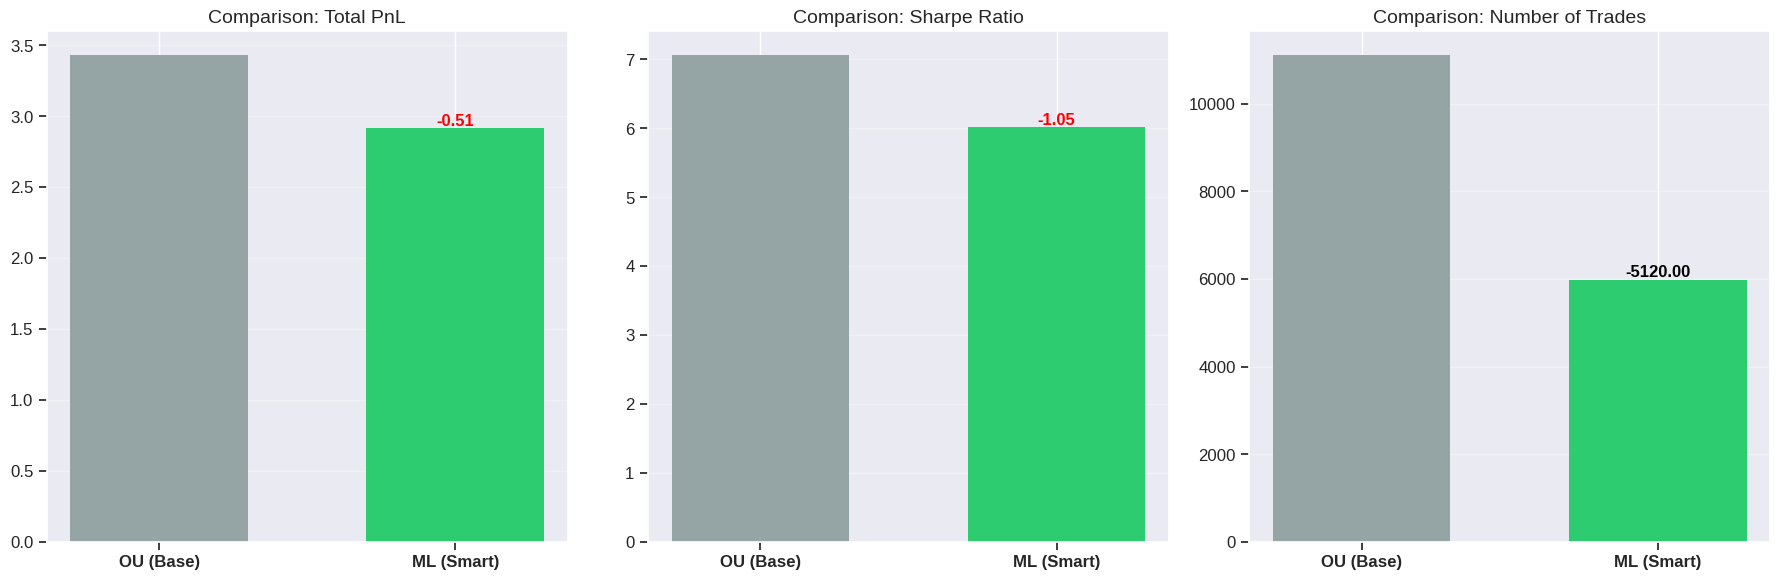

In [20]:
# 16. FINAL REPORT: DASHBOARD

print("DETAILED PERFORMANCE REPORT: ML vs OU (NO FEES)")
# 1. STRATEGY CALCULATIONS
# A. OU Strategy (Naive) - Benchmark
test_df["sig_ou"] = (test_df["zscore"].abs() > 1.0).astype(int)
test_df["pos_ou"] = test_df["sig_ou"] * test_df["weight"]
test_df["pnl_ou"] = test_df["pos_ou"] * test_df["ou_pnl"]

# B. ML Strategy (Smart Sizing) - Challenger
# Condition: |Z-score| > 1.0 AND Proba > PROB_FLOOR (defined in Step 15)
mask_ml = (test_df["zscore"].abs() > 1.0) & (test_df["y_prob"] > PROB_FLOOR)

# Sizing: increase exposure according to model conviction
conviction = (1 + (test_df["y_prob"] - 0.5) * ML_AGRESSIVITY).clip(0, 2.0)

test_df["pos_ml"] = 0.0
test_df.loc[mask_ml, "pos_ml"] = test_df.loc[mask_ml, "weight"] * conviction[mask_ml]
test_df["pnl_ml"] = test_df["pos_ml"] * test_df["ou_pnl"]

# 2. METRIC CALCULATION FUNCTION
def get_metrics(pnl_series, positions):
    daily = pnl_series.groupby("Date").sum()
    total_pnl = daily.sum()
    std = daily.std()
    sharpe = (daily.mean() / std) * np.sqrt(252) if std != 0 else 0

    # Number of trades (Days x Assets where we are invested)
    nb_trades = (positions > 0).sum()

    # Max Drawdown
    cum = daily.cumsum()
    dd = (cum - cum.cummax()).min()

    return [total_pnl, sharpe, nb_trades, dd]

# Calculations
m_ou = get_metrics(test_df["pnl_ou"], test_df["pos_ou"])
m_ml = get_metrics(test_df["pnl_ml"], test_df["pos_ml"])

# 3. BUILD COMPARATIVE TABLE
cols = ["PnL Total", "Sharpe Ratio", "Nb Trades", "Max Drawdown"]
df_res = pd.DataFrame(
    [m_ou, m_ml],
    columns=cols,
    index=["OU Classic", "ML Smart Sizing"]
)

# Delta calculations (absolute and % difference)
delta_abs = df_res.loc["ML Smart Sizing"] - df_res.loc["OU Classic"]
delta_pct = (delta_abs / df_res.loc["OU Classic"].abs()) * 100

# Table display
print("\nNUMERICAL RESULTS:")
pd.options.display.float_format = '{:+.2f}'.format
display(df_res)

print("\nGAIN ANALYSIS:")
print(f"   -> Total PnL : {delta_abs['PnL Total']:+.2f}  (i.e. {delta_pct['PnL Total']:+.1f}%)")
print(f"   -> Sharpe    : {delta_abs['Sharpe Ratio']:+.2f}  (i.e. {delta_pct['Sharpe Ratio']:+.1f}%)")
print(f"   -> Activity  : {delta_abs['Nb Trades']:+.0f} trades vs benchmark.")

# 4. VISUALIZATION (BAR CHART)
vals_ou = m_ou[:3]  # PnL, Sharpe, Nb Trades
vals_ml = m_ml[:3]
metrics_names = ["Total PnL", "Sharpe Ratio", "Number of Trades"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['#95a5a6', '#2ecc71']  # Grey vs Green

for i, ax in enumerate(axes):
    x = np.arange(2)
    vals = [vals_ou[i], vals_ml[i]]
    ax.bar(x, vals, color=colors, width=0.6)
    ax.set_xticks(x)
    ax.set_xticklabels(['OU (Base)', 'ML (Smart)'], fontweight='bold')
    ax.set_title(f"Comparison: {metrics_names[i]}", fontsize=14)

    # Display delta on the chart
    delta = vals[1] - vals[0]
    sign = "+" if delta > 0 else ""

    # Text color: Green if improvement (PnL/Sharpe up), Blue/Black otherwise
    txt_color = 'green' if (i < 2 and delta > 0) else 'black'
    if i < 2 and delta < 0:
        txt_color = 'red'

    ax.text(
        1, vals[1],
        f"{sign}{delta:.2f}",
        ha='center', va='bottom',
        fontweight='bold', fontsize=12,
        color=txt_color
    )
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
